# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# first, we import the data saved in assignment 8 on the scenario discovery results resulting from MORDM
# note, this data already contains only results for utility < 0.25
from ema_workbench import load_results

experiments, outcomes = load_results('results/selected_results.tar.gz') 

In [3]:
pd_data = pd.DataFrame.from_dict(outcomes)
pd_data.head()

,max_P,utility,inertia,reliability
0,0.235882,0.141377,0.99,1.0
1,0.258088,0.130929,0.99,1.0
2,0.160184,0.179227,0.99,1.0
3,0.183292,0.147317,0.99,1.0
4,0.167418,0.152619,0.99,1.0


## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


To select 4 scenarios, we try to find under which scenarios represent the worst-case scenario the best. This entails that the max_p is as high as possible while the utility, inertia, and reliability are as low as possible. Hence, for every outcome of interest, we find where they are maximal/minimal.

In [4]:
# find the indexes of the worst-case scenarios
print(pd_data.idxmax())
print(pd_data.idxmin())

max_P          186
utility        176
inertia          0
reliability      0
dtype: int64
max_P          130
utility        103
inertia        203
reliability    168
dtype: int64


In the worst-case, the max_p is as high as possible and the utility, inertia and reliability as low as possible. 

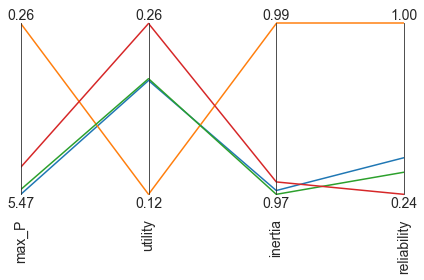

In [5]:
from ema_workbench.analysis import parcoords

worst_case = pd_data.loc[[186, 103, 203, 168]]

axes = parcoords.ParallelAxes(worst_case)
axes.plot(worst_case)
axes.invert_axis('max_P')
plt.show()

While selecting the worst-case scenarios we did focus only on one variable at the time. The above plot demonstrates, however, that this approach ignores interdependencies between the outcomes of interest. For instance, when the reliability is minimized (red line) as to represent a worst-case scenario, the utiliy and inertia actually are not really that bad performing. This indicates that in order to improve the scenario discovery, it is necessary to find scenario in which the outcomes joinlty are as bad as possible. 

In [6]:
# select the input data that represents the worst-cases, i.e. the scenarios
indexes_scenarios = [186, 103, 203, 168]
scenarios = experiments.loc[indexes_scenarios, ['b', 'delta', 'mean', 'q', 'stdev']]
scenarios

,b,delta,mean,q,stdev
186,0.206477,0.937797,0.033160,3.177726,0.003265
103,0.254683,0.930047,0.045286,3.379665,0.003704
203,0.210916,0.933064,0.029097,2.968296,0.002436
168,0.242748,0.935222,0.038325,2.873391,0.001014


In [7]:
# we now make 'Scenario' objects to be compatible with the ema_workbench 
from ema_workbench import Scenario

scenarios = [Scenario(f"Scenario index: {index}" , **row) for index, row in scenarios.iterrows()]

Now that we have the scenarios, we start to find pareto approximate sets using the same inputs as in assignment 8.

In [8]:
# instantiate the lake_model
from dps_lake_model import lake_model

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_model)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter("c1", -2, 2),
                    RealParameter("c2", -2, 2),
                    RealParameter("r1", 0, 2),
                    RealParameter("r2", 0, 2),
                    RealParameter("w1", 0, 1)]

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

lake_model.constantcs = [Constant('alpha', 0.41),
                         Constant('reps', 150)]

In [ ]:
# perform the analysis
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import Constraint

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

constraints = [Constraint("max pollution", outcome_names="max_P",
                          function=lambda x:max(0, x-5))]

nfe = 10000 
results_deep = []
convergence_all = []

for scenario in scenarios:
    with MultiprocessingEvaluator(lake_model) as evaluator:
        results_runs, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                        epsilons=[0.05, 0.05, 0.05, 0.05],
                                        convergence=convergence_metrics,
                                        constraints=constraints,
                                        reference=scenario)
        
        results_deep.append(results_runs)
        convergence_all.append(convergence)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 497/10000 nfe


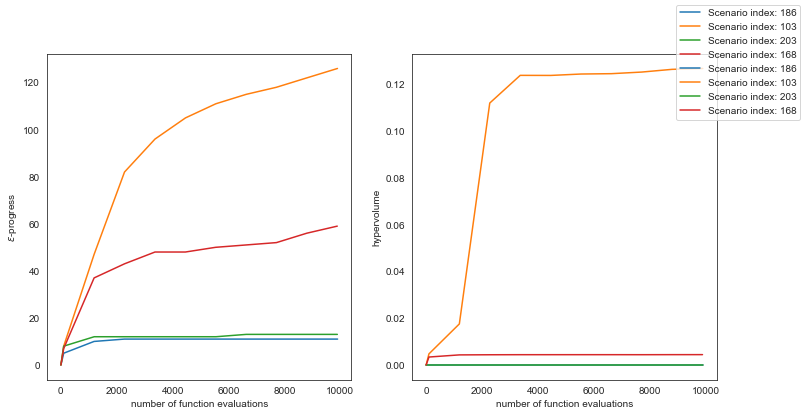

In [12]:
# plot the results
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,6))

for i, con in enumerate(convergence_all):
    ax1.plot(con.nfe, con.epsilon_progress, label=f'Scenario index: {indexes_scenarios[i]}')
    ax2.plot(con.nfe, con.hypervolume, label=f'Scenario index: {indexes_scenarios[i]}')

ax1.set_ylabel('$\epsilon$-progress')
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.legend()
plt.show()

Similar as in assignment 8, at 10000 we can effectively see a convergence to a certain value for the hypervolume whereas the epsilon has not yet fully converged. This suggests that we might need additional runs.

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [13]:
# here, we turn every pareto solution into a policy object
from ema_workbench import Policy

policies = []
for i, pareto in enumerate(results_deep):
    outcomes_of_interest = pareto.loc[:, ['c1', 'c2', 'r1', 'r2', 'w1']]
    for j, row in outcomes_of_interest.iterrows():
        policy = Policy(f'Scenario index: {indexes_scenarios[i]}, pareto outcome {j}', **row.to_dict())
        policies.append(policy)

In [14]:
# Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_pareto = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 18 policies * 1 model(s) = 18000 experiments
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 5400 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12600 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 16200 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [15]:
# calculate the domain criteria
experiments_pareto, outcomes_pareto = results_pareto

thresholds = {'utility':0.75, 'inertia':0.99, 'reliability':0.8} # from paper

all_metrics = {}
for policy in experiments_pareto.policy.unique():
    logical = experiments_pareto.policy == policy
    metrics = {}
    
    for outcome, values in outcomes_pareto.items():
        if outcome == 'max_P':
            continue
        else:
            n = np.sum(values[logical] >= thresholds[outcome])
        metrics[outcome] = n/1000 
        
    all_metrics[policy] = metrics
        
all_metrics = pd.DataFrame.from_dict(all_metrics).T

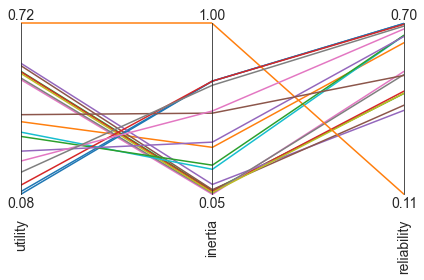

In [16]:
# plot results of domain criterion
limits = parcoords.get_limits(all_metrics)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(all_metrics)
plt.show()

In [18]:
# To calculate the regret we find the maximum value for each outcome under each policy with the same values for the uncertainties
# Then, we calculate the regret and find the maximum regret to study which is the policy that has the lowest maximum regret
outcomes_names = ['inertia','utility','reliability']
n_policies = len(policies)
n_experiments = len(experiments_pareto)
n_exp_pol = n_experiments/n_policies

final_regret = {}
for outcome in outcomes_names:
    policy_dict = {}

    for i in range(1, n_policies+1):
        # We first find the maximum value for each outcome under all policies
        policy_row = outcomes_pareto[outcome][int(n_exp_pol*(i-1)): int(n_exp_pol*i)]
        policy_dict['policy'+f"{i}"] = policy_row
    policy_df = pd.DataFrame.from_dict(policy_dict)
    maxValuesObj = policy_df.max(axis=1)
    regret_row = abs(policy_df.sub(maxValuesObj, axis='index'))
    final_regret[outcome] = regret_row.max()

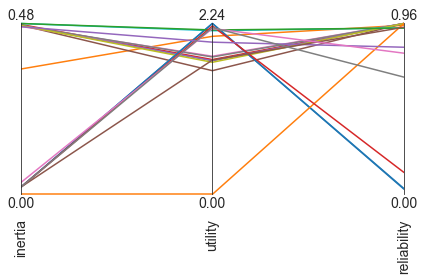

In [19]:
regret_df = pd.DataFrame.from_dict(final_regret)
limits = parcoords.get_limits(regret_df)
limits.loc[0, ['utility', 'inertia', 'reliability']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(regret_df)
plt.show()

From the above plot we can see that there are some policies that perform bad over all outcomes (eg the green one) and many that demonstrate trade-offs between different optimal outcomes. For utility, only one policy option demonstartes a low regret, but it performs fairly bad on the criteria of reliability. This means that overall, either the yellow, blue or red policy may be options to investigate further because they score well on 2/3 criteria. 

